# Sentimental Analysis of Youtube Comments

Project analyzes the comments of Youtube videos on a given date and attaches a sentiment polarity to the comments using machine learning models trained on a subset of the comments data. 

## Initialization

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re
import string
import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ericmacdougall/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Preprocessing

In [6]:
# Load the datasets safely, ignoring malformed lines
us_videos = pd.read_csv('USvideos.csv', on_bad_lines='skip', encoding='utf-8', low_memory=False)
us_comments = pd.read_csv('UScomments.csv', on_bad_lines='skip', encoding='utf-8', low_memory=False)

# Preview the datasets
print("US Videos:")
display(us_videos.head())

print("US Comments:")
display(us_comments.head())


US Videos:


,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,logan paul vlog|logan paul|logan|paul|olympics...,4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,K4wEI5zhHB0,iPhone X — Introducing iPhone X — Apple,Apple,28,Apple|iPhone 10|iPhone Ten|iPhone|Portrait Lig...,7860119,185853,26679,0,https://i.ytimg.com/vi/K4wEI5zhHB0/default.jpg,13.09
2,cLdxuaxaQwc,My Response,PewDiePie,22,[none],5845909,576597,39774,170708,https://i.ytimg.com/vi/cLdxuaxaQwc/default.jpg,13.09
3,WYYvHb03Eog,Apple iPhone X first look,The Verge,28,apple iphone x hands on|Apple iPhone X|iPhone ...,2642103,24975,4542,12829,https://i.ytimg.com/vi/WYYvHb03Eog/default.jpg,13.09
4,sjlHnJvXdQs,iPhone X (parody),jacksfilms,23,jacksfilms|parody|parodies|iphone|iphone x|iph...,1168130,96666,568,6666,https://i.ytimg.com/vi/sjlHnJvXdQs/default.jpg,13.09


US Comments:


,video_id,comment_text,likes,replies
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,XpVt6Z1Gjjo,trending 😉,3,0


In [7]:
us_videos.sample(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
4897,SqUXhozARl4,Worker Finds Secret Room in Home During Renova...,ViralHog,22,viralhog|lottery|killer|secret|room|renovation...,65608,144,14,56,https://i.ytimg.com/vi/SqUXhozARl4/default.jpg,7.10
822,Q2Ku7ELCBag,PLAYING WITH MAGIC MAKEUP?? | NikkieTutorials,NikkieTutorials,26,playing with magic makeup|magic makeup|rose ma...,1715898,96479,1271,8973,https://i.ytimg.com/vi/Q2Ku7ELCBag/default.jpg,17.09
4200,TaxAsHhex10,Colbert To Trump: 'Doing Nothing Is Cowardice',The Late Show with Stephen Colbert,24,The Late Show|Stephen Colbert|Colbert|Late Sho...,1819923,57412,7235,14963,https://i.ytimg.com/vi/TaxAsHhex10/default.jpg,4.10
2965,FpZ1sIjQrf4,Types Of Guys Your BFF Dates (ft. Alex Wassabi...,IISuperwomanII,23,iisuperwomanii|iisuperwomenii|superwoman|super...,3877130,214976,2437,23636,https://i.ytimg.com/vi/FpZ1sIjQrf4/default.jpg,27.09
6132,N1bJ5Vv3iUg,3AM Challenge In A Haunted Castle (SCARY),Rclbeauty101,24,3 am challenge in a haunted castle|frankenstei...,292191,11673,233,6334,https://i.ytimg.com/vi/N1bJ5Vv3iUg/default.jpg,13.10


In [8]:
us_videos['tags'] = us_videos['tags'].fillna('').astype(str)
us_videos.loc[:, 'tags'] = us_videos['tags'].str.replace('|', ', ', regex=False)
us_videos['tags'].sample(5)

5711    nails, nail art, nail tutorial, beauty tutoria...
4201    gmm, good mythical morning, good mythical morn...
212     The Opposition with Jordan Klepper, The Opposi...
3431    Matt Stonie, Megatoad, Competitive Eating, Foo...
7073    Astronaut Randy Bresnik, Randy Bresnik, NASA, ...
Name: tags, dtype: object

Cell replaces the pipe separators in the tags field with a comma and a space for easier readability.

In [10]:
us_videos.nunique() / us_videos.shape[0]

video_id          0.295796
title             0.300050
channel_title     0.153904
category_id       0.002002
tags              0.275776
views             0.993368
likes             0.828829
dislikes          0.316692
comment_total     0.519520
thumbnail_link    0.295796
date              0.005005
dtype: float64

The field 'video_id' does not act as a primary key for us_videos. Cell divides all unique values in each field by length of dataframe.

In [12]:
us_videos['video_id'].duplicated().sum()

5628

The dataframe us_videos has a significant amount of duplicates. This does not necessarily need to be corrected.

In [14]:
# Check basic info
print("Videos dataset info:")
print(us_videos.info())
print("\nComments dataset info:")
print(us_comments.info())

# Check for missing values
print("\nMissing values in us_videos:")
print(us_videos.isnull().sum())

print("\nMissing values in us_comments:")
print(us_comments.isnull().sum())

# Merge comments with video metadata for context (on video_id)
merged_data = pd.merge(us_comments, us_videos, on='video_id', how='left')

# Show the first few rows of the merged data
merged_data.head()

Videos dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7992 entries, 0 to 7991
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        7992 non-null   object 
 1   title           7992 non-null   object 
 2   channel_title   7992 non-null   object 
 3   category_id     7992 non-null   int64  
 4   tags            7992 non-null   object 
 5   views           7992 non-null   int64  
 6   likes           7992 non-null   int64  
 7   dislikes        7992 non-null   int64  
 8   comment_total   7992 non-null   int64  
 9   thumbnail_link  7992 non-null   object 
 10  date            7992 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 686.9+ KB
None

Comments dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691400 entries, 0 to 691399
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   -----

,video_id,comment_text,likes_x,replies,title,channel_title,category_id,tags,views,likes_y,dislikes,comment_total,thumbnail_link,date
0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,"logan paul vlog, logan paul, logan, paul, olym...",4394029,320053,5931,46245,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,13.09
1,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,"logan paul vlog, logan paul, logan, paul, olym...",5457497,349857,17479,52483,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,14.09
2,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,"logan paul vlog, logan paul, logan, paul, olym...",5854127,361422,22023,54671,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,15.09
3,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,"logan paul vlog, logan paul, logan, paul, olym...",5997736,366401,22885,39626,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,16.09
4,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0,1 YEAR OF VLOGGING -- HOW LOGAN PAUL CHANGED Y...,Logan Paul Vlogs,24,"logan paul vlog, logan paul, logan, paul, olym...",6109026,369963,23207,38850,https://i.ytimg.com/vi/XpVt6Z1Gjjo/default.jpg,17.09


In [15]:
# Drop rows with missing comment_text
merged_data = merged_data.dropna(subset=['comment_text'])
merged_data = merged_data.rename(columns={'likes_y': 'video_likes', 'dislikes': 'video_dislikes', 'likes_x': 'comments_likes'})

# Convert likes and replies to numeric
merged_data['video_likes'] = pd.to_numeric(merged_data['video_likes'], errors='coerce')
merged_data['comments_likes'] = pd.to_numeric(merged_data['comments_likes'], errors='coerce')
merged_data['replies'] = pd.to_numeric(merged_data['replies'], errors='coerce')

In [16]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2940803 entries, 0 to 2940929
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   video_id        object 
 1   comment_text    object 
 2   comments_likes  float64
 3   replies         float64
 4   title           object 
 5   channel_title   object 
 6   category_id     int64  
 7   tags            object 
 8   views           int64  
 9   video_likes     int64  
 10  video_dislikes  int64  
 11  comment_total   int64  
 12  thumbnail_link  object 
 13  date            float64
dtypes: float64(3), int64(5), object(6)
memory usage: 336.5+ MB


In [17]:
# Check for missing values
print("🔍 Missing values:\n")
print(merged_data.isnull().sum())

# Check data types
print("\n🧱 Data types:\n")
print(merged_data.dtypes)

# Check for duplicate comments
duplicate_comments = merged_data.duplicated(subset=["video_id", "comment_text"])
print(f"\n📎 Duplicate comments found: {duplicate_comments.sum()}")

# Drop missing comment_text (if still present)
merged_data = merged_data.dropna(subset=['comment_text'])

# Check again after conversions
print("\n📊 Summary stats for likes and replies:\n")
print(merged_data[['comments_likes', 'replies']].describe())


🔍 Missing values:

video_id          0
comment_text      0
comments_likes    4
replies           4
title             0
channel_title     0
category_id       0
tags              0
views             0
video_likes       0
video_dislikes    0
comment_total     0
thumbnail_link    0
date              0
dtype: int64

🧱 Data types:

video_id           object
comment_text       object
comments_likes    float64
replies           float64
title              object
channel_title      object
category_id         int64
tags               object
views               int64
video_likes         int64
video_dislikes      int64
comment_total       int64
thumbnail_link     object
date              float64
dtype: object

📎 Duplicate comments found: 2490285

📊 Summary stats for likes and replies:

       comments_likes       replies
count    2.940799e+06  2.940799e+06
mean     6.028855e+00  4.285771e-01
std      2.524891e+02  1.023677e+01
min      0.000000e+00  0.000000e+00
25%      0.000000e+00  0.000000e+00


In [18]:
merged_data.dropna(subset=['comments_likes', 'replies'], inplace=True)

In [19]:
merged_data.drop_duplicates(subset=['video_id', 'comment_text'], inplace=True)

In [20]:
# Drop missing likes and replies
merged_data.dropna(subset=['comments_likes', 'replies'], inplace=True)

# Drop exact duplicate comments
merged_data.drop_duplicates(subset=['video_id', 'comment_text'], inplace=True)

In [21]:
# Use your correct merged dataset name
df_model = merged_data.copy()

# Lemmatize comment text
lemmatizer = WordNetLemmatizer()

def get_lemmas(text):
    lemmas = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(lemmas)

df_model['comment_text'] = df_model['comment_text'].apply(get_lemmas)

# Drop columns not useful for modeling
df_model = df_model.drop(columns=['video_id', 'thumbnail_link', 'tags', 'title'])

# Encode 'channel_title'
le = LabelEncoder()
df_model['channel_title'] = le.fit_transform(df_model['channel_title'])

# ✅ Confirm cleanup
print("\n📌 Dtypes after encoding:\n", df_model.dtypes)
print("\n📊 Preview:\n")
display(df_model.head())



📌 Dtypes after encoding:
 comment_text       object
comments_likes    float64
replies           float64
channel_title       int64
category_id         int64
views               int64
video_likes         int64
video_dislikes      int64
comment_total       int64
date              float64
dtype: object

📊 Preview:



,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date
0,Logan Paul it's yo big day ‼️‼️‼️,4.0,0.0,563,24,4394029,320053,5931,46245,13.09
7,I've been following you from the start of your...,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
14,Say hi to Kong and maverick for me,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
21,MY FAN . attendance,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
28,trending 😉,3.0,0.0,563,24,4394029,320053,5931,46245,13.09


In [22]:
df_model = df_model.reset_index(drop=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450517 entries, 0 to 450516
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   comment_text    450517 non-null  object 
 1   comments_likes  450517 non-null  float64
 2   replies         450517 non-null  float64
 3   channel_title   450517 non-null  int64  
 4   category_id     450517 non-null  int64  
 5   views           450517 non-null  int64  
 6   video_likes     450517 non-null  int64  
 7   video_dislikes  450517 non-null  int64  
 8   comment_total   450517 non-null  int64  
 9   date            450517 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 34.4+ MB


## EDA

EDA is conducted on the datasets us_videos and df_model. The dataset df_model represents a merged dataset of us_comments and us_videos with several fields dropped. Given that us_videos and df_model share some of the same data, there is some overlap in the graphs and analysis.

### df_model EDA

/var/folders/3s/2dmkjq450zz_66pdw012m6ch0000gn/T/ipykernel_65029/1630224714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_comments.loc[:, 'comment_length'] = short_comments['comment_text'].str.split().apply(len)


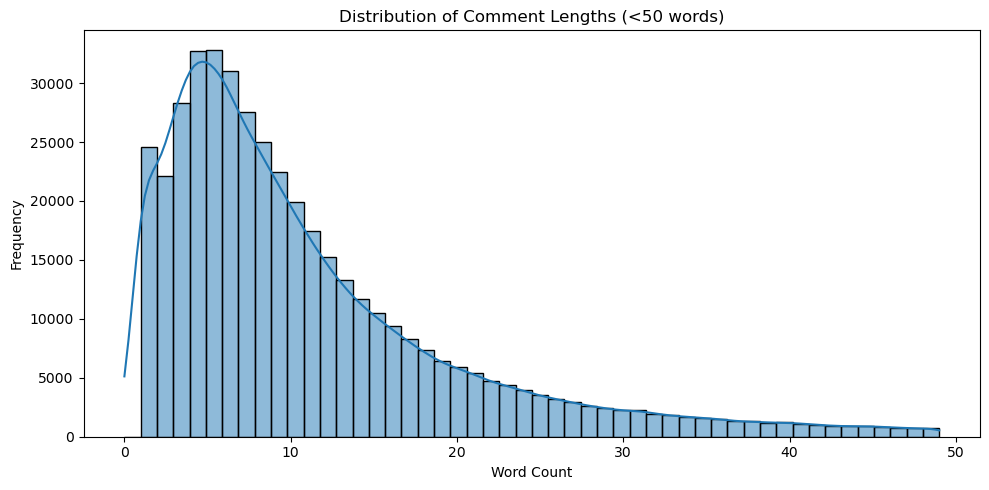

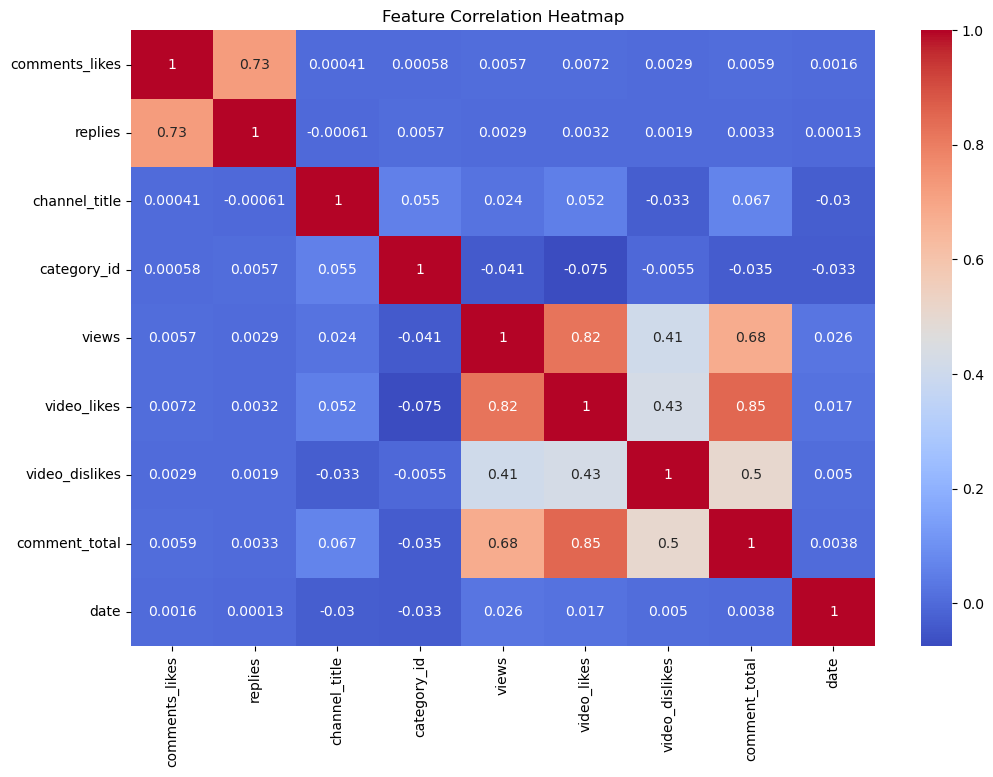

In [26]:
# Comment length distribution (zoomed in to <50 words)
short_comments = df_model[df_model['comment_text'].str.split().apply(len) < 50]
short_comments.loc[:, 'comment_length'] = short_comments['comment_text'].str.split().apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(short_comments['comment_length'], bins=50, kde=True)
plt.title("Distribution of Comment Lengths (<50 words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Heatmap of numeric feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_model.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


📊 Comment Length Distribution (Trimmed to <100 words)
The majority of YouTube comments are short and concise, with a clear right-skewed distribution. Most comments fall under 10–15 words, and there's a rapid drop-off as word count increases. This aligns with typical user behavior on social platforms, where brief reactions dominate.

Trimming at 100 words helps reveal the true distribution by removing outliers that could distort analysis. This decision ensures better performance for NLP models and more consistent sentiment prediction, especially when using models trained on short text like VADER or BERT-based classifiers.

✅ Strong Correlations (|correlation| > 0.6)
These indicate strong linear relationships:

Feature Pair	Correlation	Comment
video_likes & views	0.82	More views generally mean more likes. Strong engagement signal.
comment_total & video_likes	0.85	Videos with more likes also get more comments.
comment_total & views	0.68	More views = more comments — strong engagement indicator.
comments_likes & replies	0.73	Comments with more likes also get more replies — shows user interaction.
video_dislikes & video_likes	0.43	Positively related — possibly controversial videos?
video_dislikes & views	0.41	More visibility also brings more dislikes.
❌ Weak or Negligible Correlations (|correlation| < 0.1)
These features don't show meaningful linear relationships:

Feature	Correlation Range	Comment
comment_length	-0.025 to 0.02	Very weak correlation with all features — long/short comments don’t affect engagement much.
channel_title	~0.02 to ~0.06	Encoded as integers, low correlation implies it doesn’t affect numerical outcomes directly.
category_id	-0.07 to 0.05	Not strongly correlated to likes, views, or comment activity. Might be useful for classification, not regression.
date	-0.03 to 0.02	Weak influence — possibly could capture seasonal patterns, but not impactful on its own.
🧠 Conclusion:
Keep: video_likes, views, comment_total, video_dislikes, comments_likes, replies — they capture engagement and user activity.

Consider dropping or encoding better: channel_title, comment_length, date, category_id — they offer limited linear insights but may still help with tree-based models or NLP tasks.

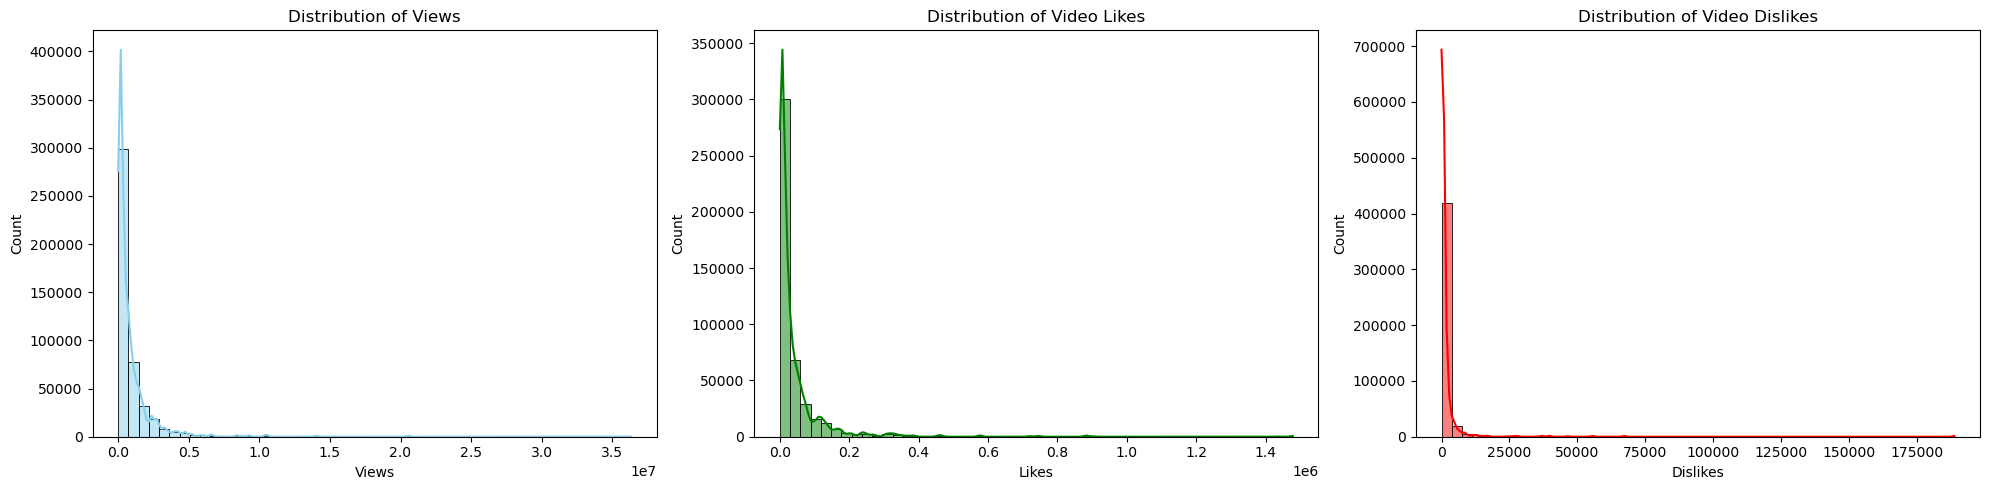

In [29]:
# Plot distribution of views, likes, and dislikes
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(df_model['views'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Views')
axes[0].set_xlabel('Views')

sns.histplot(df_model['video_likes'], bins=50, kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Video Likes')
axes[1].set_xlabel('Likes')

sns.histplot(df_model['video_dislikes'], bins=50, kde=True, ax=axes[2], color='red')
axes[2].set_title('Distribution of Video Dislikes')
axes[2].set_xlabel('Dislikes')

plt.tight_layout()
plt.show()


📊 Distribution Analysis Conclusion
Right-Skewed Distributions
All three variables — views, likes, and dislikes — exhibit a strong right-skewed distribution. This suggests that:

The majority of videos receive relatively low engagement (low views, likes, dislikes).

A small number of videos receive disproportionately high engagement, likely due to viral popularity or trending topics.

Views Distribution

Most videos have less than 5 million views, with the bulk concentrated under 1 million.

A few outlier videos surpass 20M+ views, indicating high viral potential.

Likes Distribution

Similarly, likes are concentrated under 200k, with a few outliers reaching over 1 million.

This aligns with how most YouTube videos receive modest likes unless significantly promoted or viral.

Video Dislikes Distribution

Dislikes are typically much lower than likes, often under 20k.

This suggests viewers are generally more inclined to like than dislike (unless the content is controversial).

In [31]:
# Load the category mapping JSON file. Provides dictionary to map indices to categories.
with open('US_category_id.json') as f:
    categories_data = json.load(f)

# Extract the ID-to-title mapping from the JSON
category_mapping = {}
for item in categories_data['items']:
    cat_id = int(item['id'])
    cat_name = item['snippet']['title']
    category_mapping[cat_id] = cat_name

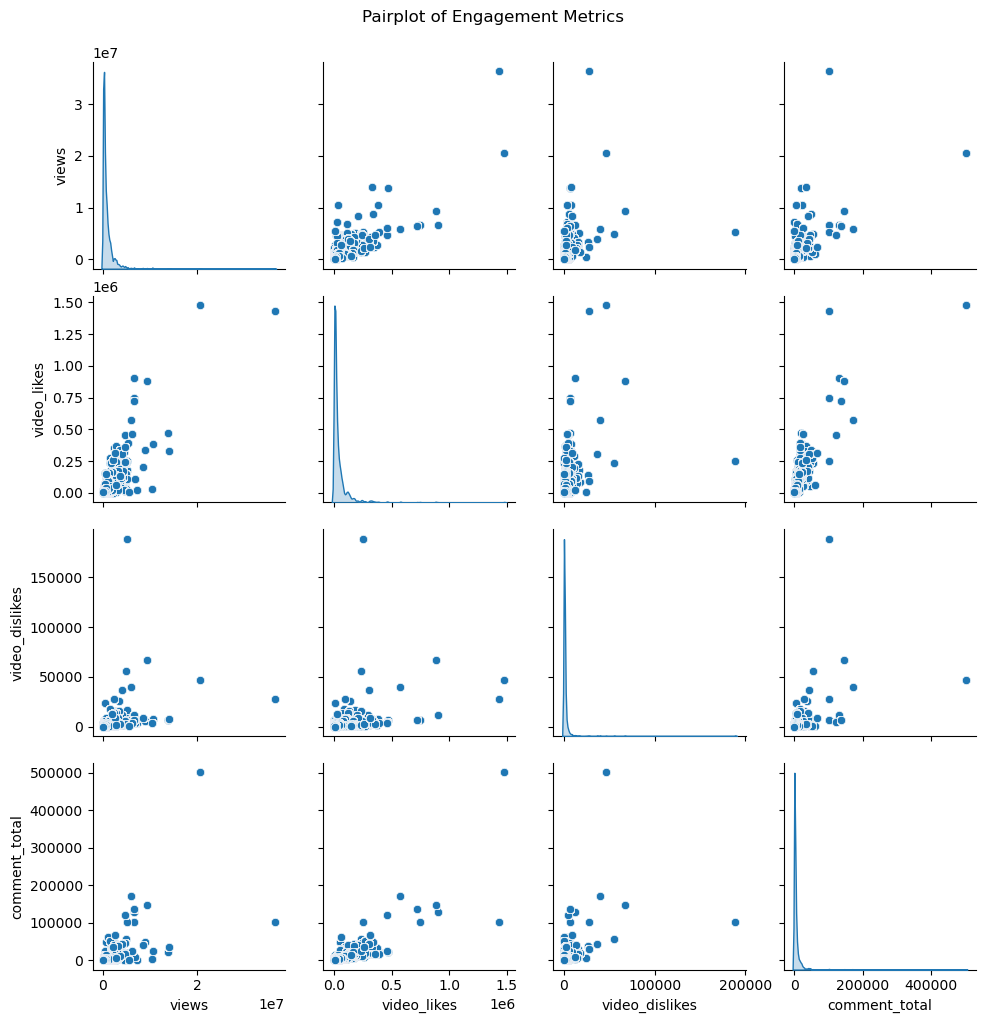

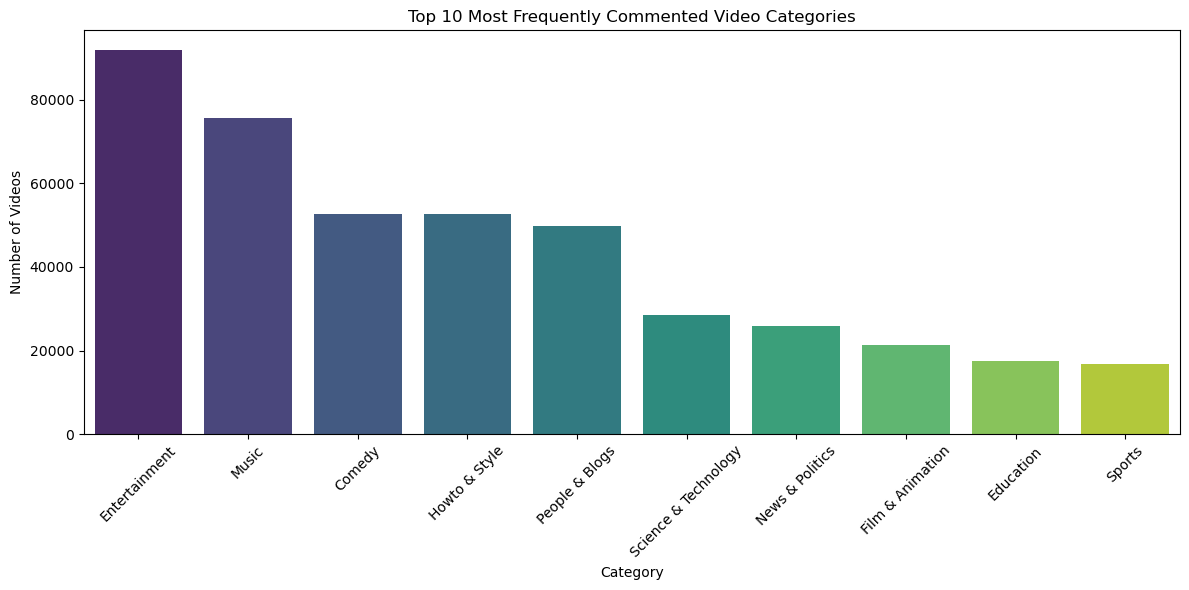

In [32]:
import warnings
warnings.filterwarnings('ignore')

# Correlation between views, likes, dislikes, and comment_total
engagement_features = df_model[['views', 'video_likes', 'video_dislikes', 'comment_total']]
sns.pairplot(engagement_features, kind='scatter', diag_kind='kde')
plt.suptitle("Pairplot of Engagement Metrics", y=1.02)
plt.show()

# Bar plot for most frequent categories
plt.figure(figsize=(12, 6))
category_counts = df_model['category_id'].value_counts().head(10)
sns.barplot(x=category_counts.index.map(category_mapping), y=category_counts.values, palette="viridis")
plt.title("Top 10 Most Frequently Commented Video Categories")
plt.xlabel("Category")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Pairplot of Engagement Metrics
This pairplot helps visualize relationships between:

views

Video Likes

Video Dislikes

comment_total

🔍 Key Observations:
Strong positive correlation between views and video_likes — as expected, more views generally yield more likes.

Dislikes and comments also increase with views but appear more scattered, suggesting they vary more depending on content.

Outliers are visible: some videos have disproportionately high views, likes, or comments, likely viral content.

Non-linear relationships are common — trends don’t follow strict lines, which means ML models may benefit from non-linear methods (like trees or neural networks).

🎥 Top 10 Most Frequent Video Categories
🔍 Key Observations:
Category 24 is the most dominant, followed by 10, 26, and 23.

These categories likely represent high-volume video types like Entertainment, Music, and People & Blogs.

Focusing on these frequent categories can help identify audience sentiment patterns more reliably due to larger sample sizes.

### us_videos EDA

In [35]:
# Map category_id in videos DataFrame to category_name
us_videos['category_name'] = us_videos['category_id'].map(category_mapping)

# Preview the updated DataFrame
print("✅ Mapped Categories Sample:")
display(us_videos[['category_id', 'category_name']].drop_duplicates().sort_values('category_id'))


✅ Mapped Categories Sample:


,category_id,category_name
5,1,Film & Animation
52,2,Autos & Vehicles
20,10,Music
78,15,Pets & Animals
25,17,Sports
122,19,Travel & Events
56,20,Gaming
2,22,People & Blogs
4,23,Comedy
0,24,Entertainment


In [36]:
us_videos['category_id'].value_counts().head(10)

category_id
24    1601
10    1250
22     882
26     869
23     755
25     623
28     512
17     410
1      378
27     334
Name: count, dtype: int64

In [37]:
us_videos['category_name'].value_counts().head(10)

category_name
Entertainment           1601
Music                   1250
People & Blogs           882
Howto & Style            869
Comedy                   755
News & Politics          623
Science & Technology     512
Sports                   410
Film & Animation         378
Education                334
Name: count, dtype: int64

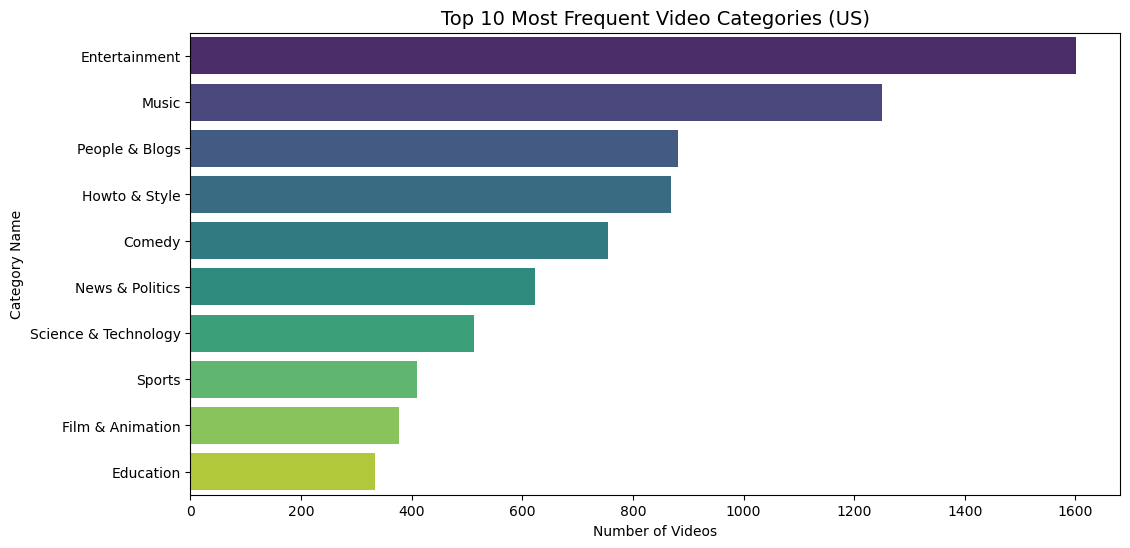

In [38]:
plt.figure(figsize=(12, 6))
top_categories = us_videos['category_name'].value_counts().head(10)

sns.barplot(x=top_categories.values, y=top_categories.index, hue=top_categories.index, palette='viridis')
plt.title('Top 10 Most Frequent Video Categories (US)', fontsize=14)
plt.xlabel('Number of Videos')
plt.ylabel('Category Name')
plt.show()

📊 Top 10 Most Frequent Video Categories (US) – Interpretation
🥇 1. Entertainment
Most dominant category with the highest number of videos.

This aligns with YouTube being heavily consumed for fun, humor, celebrity content, shows, and entertainment-focused uploads.

🎶 2. Music
Also a major category, which is expected since music videos tend to get massive views and engagement.

Music videos are typically shorter and highly shareable.

🧑‍💼 3–4. People & Blogs and Howto & Style
These categories reflect personal vlogging, tutorials, DIYs, and lifestyle content — all of which have boomed thanks to influencers and creators.

😂 5. Comedy
Still very popular, showcasing the demand for humor and meme culture on the platform.

📰 6. News & Politics
This is quite significant. It shows people use YouTube not just for entertainment but also to stay informed.

🧪 7–10. Science & Tech, Sports, Film & Animation, Education
These categories, while smaller in quantity, may still attract highly engaged audiences and should not be overlooked — especially for niche modeling and sentiment targeting.

✅ What This Means for Modeling
Categories like Entertainment, Music, and People & Blogs will have higher comment volume and are more likely to show varied sentiment polarity.

You might want to stratify some of your analysis or sentiment results by category, especially when comparing like/dislike ratios vs sentiment ratios.



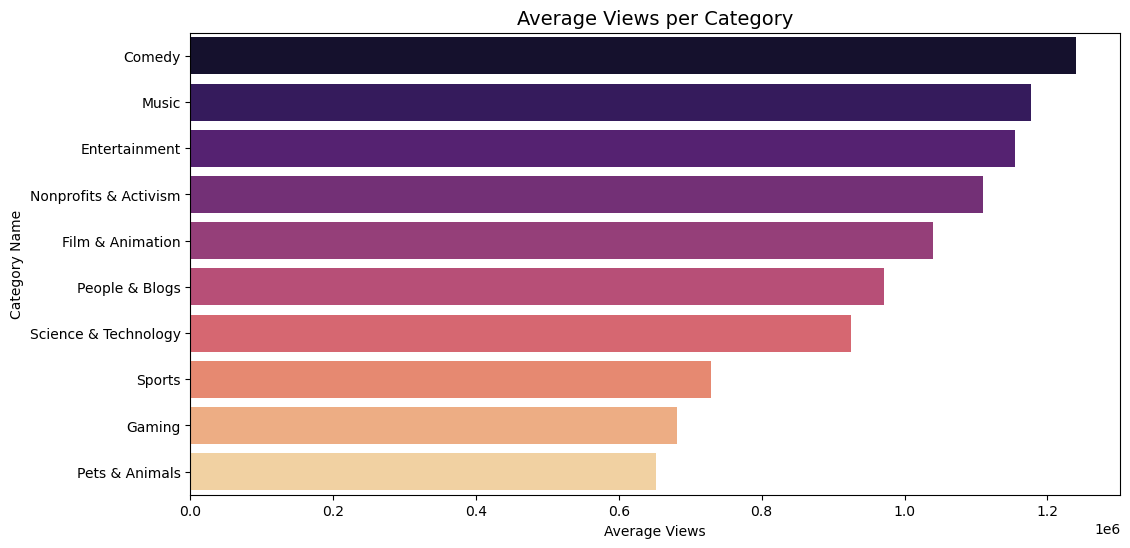

In [40]:
avg_views = us_videos.groupby('category_name')['views'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_views.values, y=avg_views.index, hue=avg_views.index, palette='magma')
plt.title('Average Views per Category', fontsize=14)
plt.xlabel('Average Views')
plt.ylabel('Category Name')
plt.show()

📊 Average Views per Category – Interpretation
Rank	Category	Insights
🥇 1	Comedy	Tops the chart with the highest average views. Likely driven by viral, short-form, and highly shareable content.
🥈 2	Music	Strong average views, often due to big releases by major artists and repeat viewing behavior.
🥉 3	Entertainment	High-performing, likely driven by trailers, show clips, celebrity interviews, etc.
✅ 4–7	Nonprofits, Film & Animation, People & Blogs, Science & Tech	These categories have solid engagement, indicating content value across varied interests (education, storytelling, personality-based).
📉 8–10	Sports, Gaming, Pets & Animals	Lower on average, which might be due to a higher quantity of uploads with more variability in content quality.
📌 Implications for Modeling
Comedy, Music, and Entertainment videos are more likely to attract extreme sentiment (strongly positive/negative) — useful for training your sentiment classifier.

Niche categories like Science & Tech or Education might have fewer but more meaningful comments — important for model generalization.

You can create category-stratified sentiment models or compare likes/dislikes vs predicted sentiment by category to reveal inconsistencies or bias.



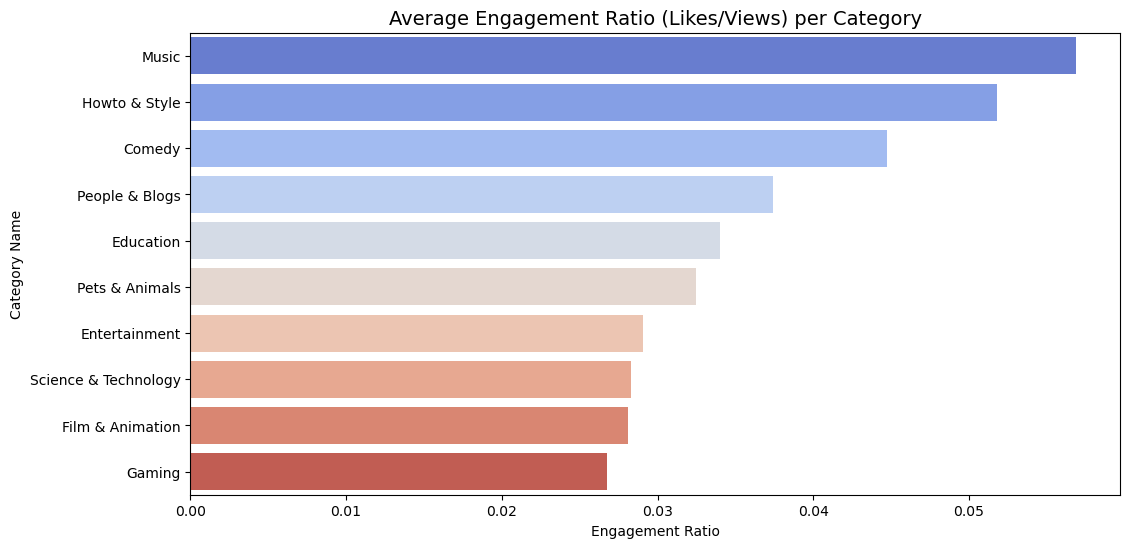

In [42]:
us_videos['engagement_ratio'] = us_videos['likes'] / us_videos['views']
engagement = us_videos.groupby('category_name')['engagement_ratio'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=engagement.values, y=engagement.index, hue=engagement.index, palette='coolwarm')
plt.title('Average Engagement Ratio (Likes/Views) per Category', fontsize=14)
plt.xlabel('Engagement Ratio')
plt.ylabel('Category Name')
plt.show()

📊 Interpretation of Engagement Ratio by Category
Rank	Category	Engagement Insights
🥇 1	Music	Highest engagement rate – fans are more likely to like music videos they enjoy, even with high view counts.
🥈 2	Howto & Style	Highly interactive audience – likely due to gratitude for tutorials and tips. Viewers often reward creators.
🥉 3	Comedy	Strong engagement, likely due to personal entertainment and shareability.
🔍 4–7	People & Blogs, Education, Pets & Animals, Entertainment	Good audience loyalty and moderate-to-high engagement. Educational and personal content builds trust.
📉 8–10	Science & Tech, Film & Animation, Gaming	Lower likes per view – possibly due to viewer passivity or less emotional connection in these formats.
🧠 Why It Matters
High engagement ratio = greater viewer satisfaction and intent to support the creator.

This is not just about views, but how invested the audience is — great for model features or exploratory analysis.

## NLP Preprocessing

In [45]:
## Text preprocessing 
import re
import nltk
from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())

def comments(texts):
    
    #getting rid of any alphanumerical characters
    texts= re.sub(r"[A-Za-z0-9]:"," ",texts)

    #getting rid of non-standard characters
    texts =re.sub(r"[^A-Za-z]"," ", texts)

    #getting rid of extra whitespaces
    texts = re.sub(r" +", " ",texts)
    
    #converting texts into lowercases
    texts = texts.lower()

    # Filter out non-English words
    filtered_words = [word for word in texts.split() if word in english_words]
    return " ".join(filtered_words)

[nltk_data] Downloading package words to
[nltk_data]     /Users/ericmacdougall/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [46]:
df_model.loc[:,'comment_text'] = df_model['comment_text'].apply(comments)

In [47]:
lem = WordNetLemmatizer()
    
def get_lemmas(text):
    lemmas= [lem.lemmatize(word) for word in text.split(" ")]
    lemmatized =" ".join(lemmas)
    return lemmatized 
df_model.loc[:,'comment_text'] = df_model['comment_text'].apply(get_lemmas)

df_model

,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date
0,it s yo big day,4.0,0.0,563,24,4394029,320053,5931,46245,13.09
1,i been following you from the start of your vi...,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
2,say hi to and maverick for me,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
3,my fan attendance,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
4,,3.0,0.0,563,24,4394029,320053,5931,46245,13.09
...,...,...,...,...,...,...,...,...,...,...
450512,lost on you my god i love this song,0.0,0.0,527,10,84755,5763,44,413,19.10
450513,i love,0.0,0.0,527,10,84755,5763,44,413,19.10
450514,l o s t o n y o u,1.0,0.0,527,10,84755,5763,44,413,19.10
450515,,0.0,0.0,527,10,84755,5763,44,413,19.10


### Vaders Model

In [49]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model,test_size=0.2, random_state=42)

In [50]:
train_reset = train.reset_index(drop=False)
train_reset.rename(columns={'index': 'row_id'}, inplace=True)

In [51]:
sia = SentimentIntensityAnalyzer()

In [52]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [53]:
res = {}
for i, row in tqdm(train_reset.iterrows(), total=len(train_reset)):
    text = row['comment_text']
    myid = row['row_id']
    res[myid] = sia.polarity_scores(text)

# res

  0%|          | 0/360413 [00:00<?, ?it/s]

In [54]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'row_id'})
vaders = vaders.merge(train_reset, how='left')

In [55]:
# vaders dataframe with the sentiment data added
vaders.tail()

,row_id,neg,neu,pos,compound,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date
360408,259178,0.000,0.816,0.184,0.4019,so i guess we will never see a video of him in...,0.0,0.0,14,25,189313,748,292,1610,5.10
360409,365838,0.000,1.000,0.000,0.0000,is this,0.0,0.0,364,26,397620,15839,631,3678,11.10
360410,131932,0.000,0.000,1.000,0.5719,perfect i,0.0,0.0,293,10,3440579,306217,2041,16488,23.09
360411,146867,0.412,0.588,0.000,-0.2732,before the are blocked,0.0,0.0,942,24,4201342,148492,3248,5105,23.09
360412,121958,0.481,0.519,0.000,-0.5719,i don t hate just baby people,0.0,0.0,821,28,138049,7866,359,886,23.09


### Evaluation Methods

In [57]:
eval_stats_all = pd.DataFrame()

In [58]:
def model_to_string(model):
    # Method records the name and parameters of each model and returns it as a string.
    model_name = type(model).__name__  # Get the class name of the model
    params = model.get_params()  # Get the model parameters
    params_str = ', '.join(f'{k}={v}' for k, v in params.items())  # Create a formatted string of parameters
    return f"{model_name}({params_str})"

In [59]:
def record_metrics(model, df_eval_stats):
    # Method records the performance of each model on the test set in a global dataframe for easy reference and comparison in the
    # 'Conclusions' section. Returns an updated dataframe.
    global eval_stats_all

    metrics_row = {
        'model_name': type(model).__name__,
        'full_model': model_to_string(model),
        'test_accuracy': df_eval_stats['test'].get('Accuracy', None),
        'test_f1': df_eval_stats['test'].get('F1', None),
        'test_roc_auc': df_eval_stats['test'].get('ROC AUC', None),
        'test_aps': df_eval_stats['test'].get('APS', None)
    }
    
    metrics_df = pd.DataFrame([metrics_row])
    
    # Concatenate the new row to the existing DataFrame
    eval_stats_all = pd.concat([eval_stats_all, metrics_df], ignore_index=True)
            
    return eval_stats_all

In [189]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target, val_features=None, val_target=None):
    # Method plots several graphs for a model's performance as well as prints out evaluation
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 

    if (val_features is None or val_target is None):
        sets = (('train', train_features, train_target), ('test', test_features, test_target))
    else: 
        sets = (('train', train_features, train_target), ('val', val_features, val_target), ('test', test_features, test_target))
    
    for type, features, target in sets:
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        elif type == 'val':
            color = 'pink'
        elif type == 'test':
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(6)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    record_metrics(model, df_eval_stats)

    print(df_eval_stats)
    plt.show()
    
    return

In [61]:
def structure_confusion_matrix(matrix):
    # This method structures a confusion_matrix instance so that it is easier read.
    print('Confusion matrixes for the model are below, first by percentage, then by instances.')
    display(pd.DataFrame(matrix, columns=['Predicted False', 'Predicted True'], index=['Is False', 'Is True']).div(matrix.sum(axis=1), axis=0))
    display(pd.DataFrame(matrix, columns=['Predicted False', 'Predicted True'], index=['Is False', 'Is True']))

### Data Splitting

In [68]:
vaders = vaders.drop(columns='row_id')
vaders.head()

,neg,neu,pos,compound,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date
0,0.175,0.417,0.408,0.4215,like the loop ha been induced too low,1.0,1.0,761,22,494926,129,90,296,28.09
1,0.000,0.605,0.395,0.8338,i don t watch a lot of but i don t recognize a...,0.0,0.0,985,25,178675,627,1012,526,19.09
2,0.000,0.688,0.312,0.8271,you have to have surround sound to make this j...,0.0,0.0,977,24,106224,10782,224,2154,11.10
3,0.156,0.844,0.000,-0.3400,removal of a brain over here in cost around wh...,0.0,0.0,224,26,41320,2178,64,796,5.10
4,0.132,0.606,0.262,0.6726,the lady formation of a changement pique wa su...,0.0,0.0,551,24,568823,64308,938,4151,12.10


In [69]:
vaders = vaders.sample(frac=1, random_state=42)

Cell randomly shuffles vaders dataset.

In [71]:
features = vaders['comment_text']
target = np.where(vaders['compound'] > 0, 1, 0)

In [72]:
from sklearn.model_selection import train_test_split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [73]:
features.shape, target.shape

((360413,), (360413,))

In [74]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((288330,), (72083,), (288330,), (72083,))

Splits are appropriate and were performed correctly.

## Modeling

In [191]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
import spacy
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords

### Model 0 - Constant

             train      test
Accuracy  0.437918  0.437371
F1        0.609100  0.608571
APS       0.437918  0.437371
ROC AUC   0.500000  0.500000


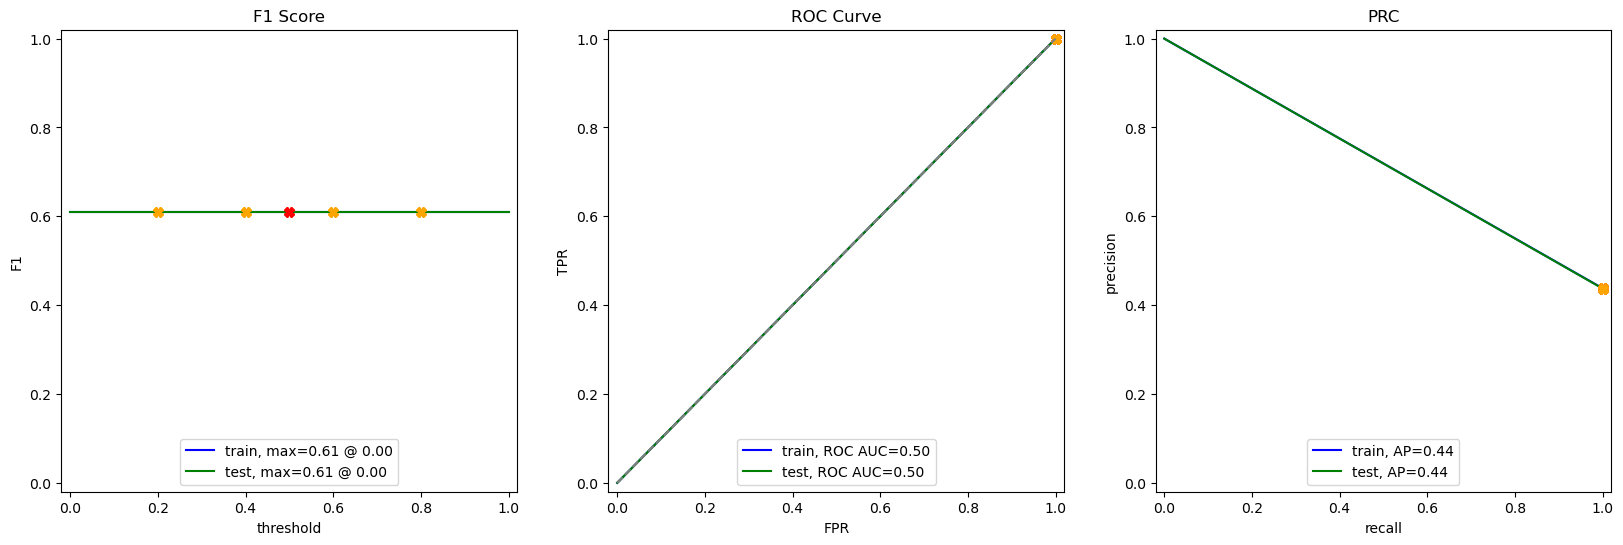

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.0,1.0
Is True,0.0,1.0


,Predicted False,Predicted True
Is False,0,40556
Is True,0,31527


In [193]:
dummy = DummyClassifier(strategy='constant', constant=1, random_state=42)
dummy.fit(features_train, target_train)
predictions = dummy.predict(features_test)

evaluate_model(dummy, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

Model provides a baseline.

### Model 1 - NLTK, TF-IDF and LR

['very', 'over', 'will', 'too', 'because', 'once', 'having', 's', 'not', 'for', 'the', 'with', 'y', 'under', 'shan', "couldn't", "it's", "hadn't", 'doesn', 'himself', 'on', 'after', 'here', 'so', 'of', "you'll", 'have', 'does', 'through', 'just', 'aren', 'don', 'o', 'where', 'ain', 'is', 'yours', 'was', 'had', 'his', 'hers', "aren't", 'ma', 'can', 'a', "wouldn't", 'about', 'd', 'doing', 'if', 'and', 'been', 'as', 're', 'wasn', 'themselves', 'hadn', "weren't", "shan't", 'nor', "she's", 'few', 'myself', 'has', 'than', "isn't", 'in', 'am', 'ourselves', 'both', 'some', "doesn't", 'but', 'now', 'itself', 'weren', "mightn't", "you'd", "you're", 'who', 'herself', 'by', 'above', 'she', 'll', 'yourself', 've', 'which', 'won', 'those', 'their', 'when', 'out', "won't", "mustn't", 'any', 'while', "hasn't", 'before', "that'll", "wasn't", 'it', 'were', 'to', "didn't", "you've", 'what', 'no', 'haven', 'be', 'wouldn', 'these', 'theirs', 'below', 'an', 'you', 'that', 'he', 'why', 'same', 'until', 'we',

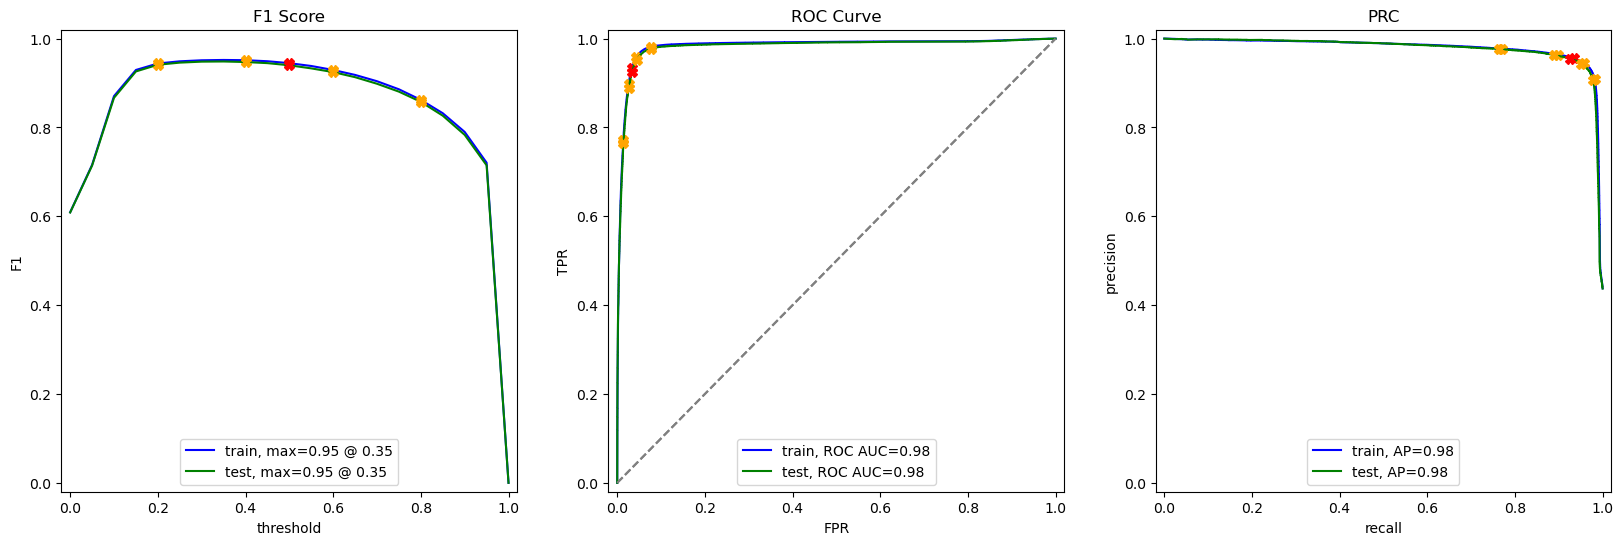

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.966072,0.033928
Is True,0.074571,0.925429


,Predicted False,Predicted True
Is False,39180,1376
Is True,2351,29176


CPU times: user 10.3 s, sys: 1.22 s, total: 11.5 s
Wall time: 13.2 s


In [196]:
%%time

stop_words = list(set(stopwords.words('english')))
print(stop_words, '\n')
# import TfidfVectorizer
corpus = vaders['comment_text']

model_1 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1)),  # Convert text to TF-IDF features
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_1.fit(features_train, target_train)

# Predict on the test data

predictions = model_1.predict(features_test)

evaluate_model(model_1, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### Model 2 - TF-IDF, LogisticRegression, and Bigrams

             train      test
Accuracy  0.836080  0.783111
F1        0.776375  0.694302
APS       0.943142  0.834127
ROC AUC   0.961617  0.844931


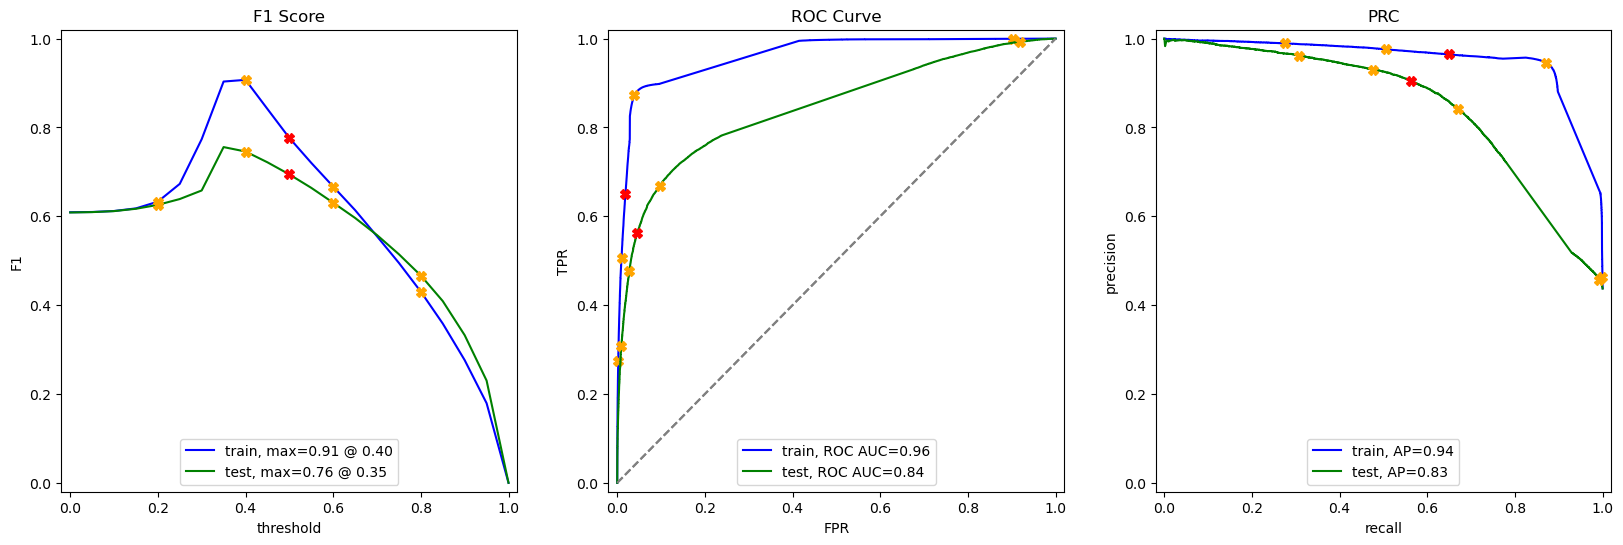

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.954113,0.045887
Is True,0.436864,0.563136


,Predicted False,Predicted True
Is False,38695,1861
Is True,13773,17754


CPU times: user 16.3 s, sys: 1.4 s, total: 17.7 s
Wall time: 17 s


In [198]:
%%time

model_2 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2)),  # Convert text to TF-IDF features
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_2.fit(features_train, target_train)

# Predict on the test data

predictions = model_2.predict(features_test)

evaluate_model(model_2, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### Model 3 - Bag of Words (BoW) and LogisticRegression

             train      test
Accuracy  0.965324  0.957091
F1        0.960203  0.950403
APS       0.978633  0.969533
ROC AUC   0.982656  0.975571


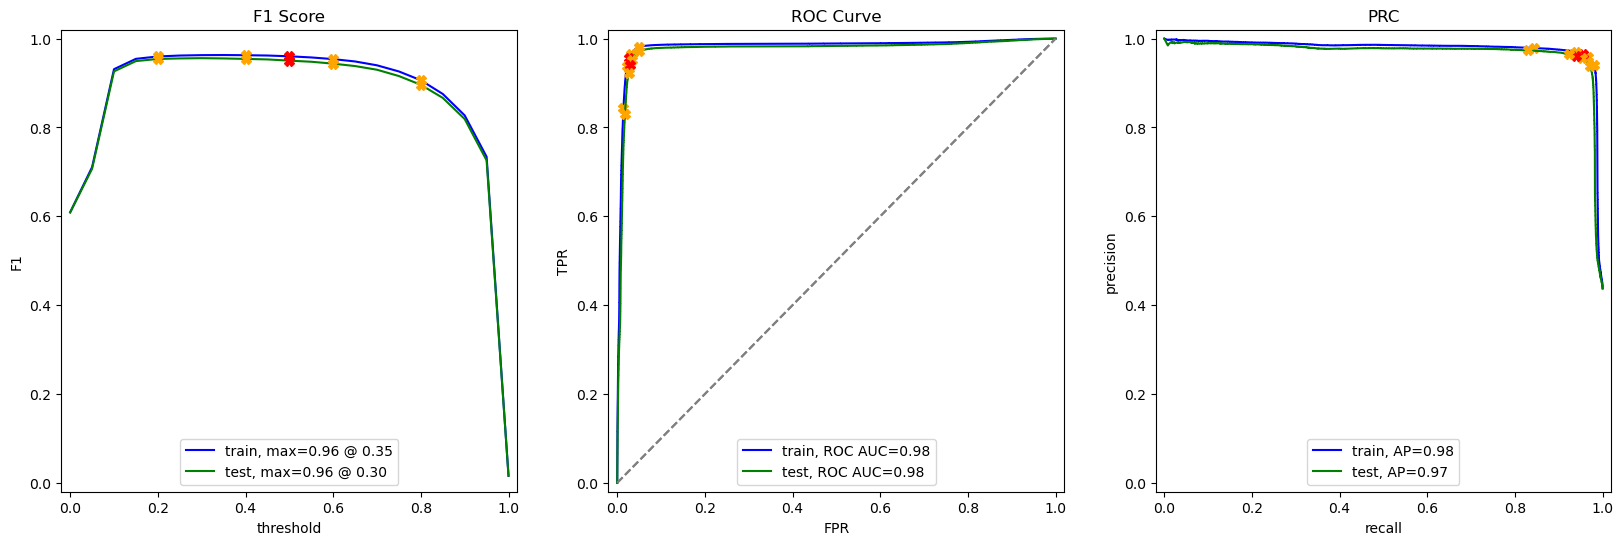

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.970387,0.029613
Is True,0.060012,0.939988


,Predicted False,Predicted True
Is False,39355,1201
Is True,1892,29635


CPU times: user 10 s, sys: 1.99 s, total: 12 s
Wall time: 11.4 s


In [200]:
%%time 
from sklearn.feature_extraction.text import CountVectorizer

# create an n-gram with n=1 and store it in the n_gram variable

model_3 = make_pipeline(
    CountVectorizer(ngram_range=(1, 1), stop_words=stop_words),  # Convert text to BoW model
    LogisticRegression(max_iter=1000)  # Logistic regression model
)

# Train the model
model_3.fit(features_train, target_train)

# Predict on the test data

predictions = model_3.predict(features_test)

evaluate_model(model_3, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### 5.5. Model 4 - TF-IDF and CatBoostClassifier

             train      test
Accuracy  0.883096  0.882330
F1        0.857968  0.856694
APS       0.921180  0.918779
ROC AUC   0.938072  0.936816


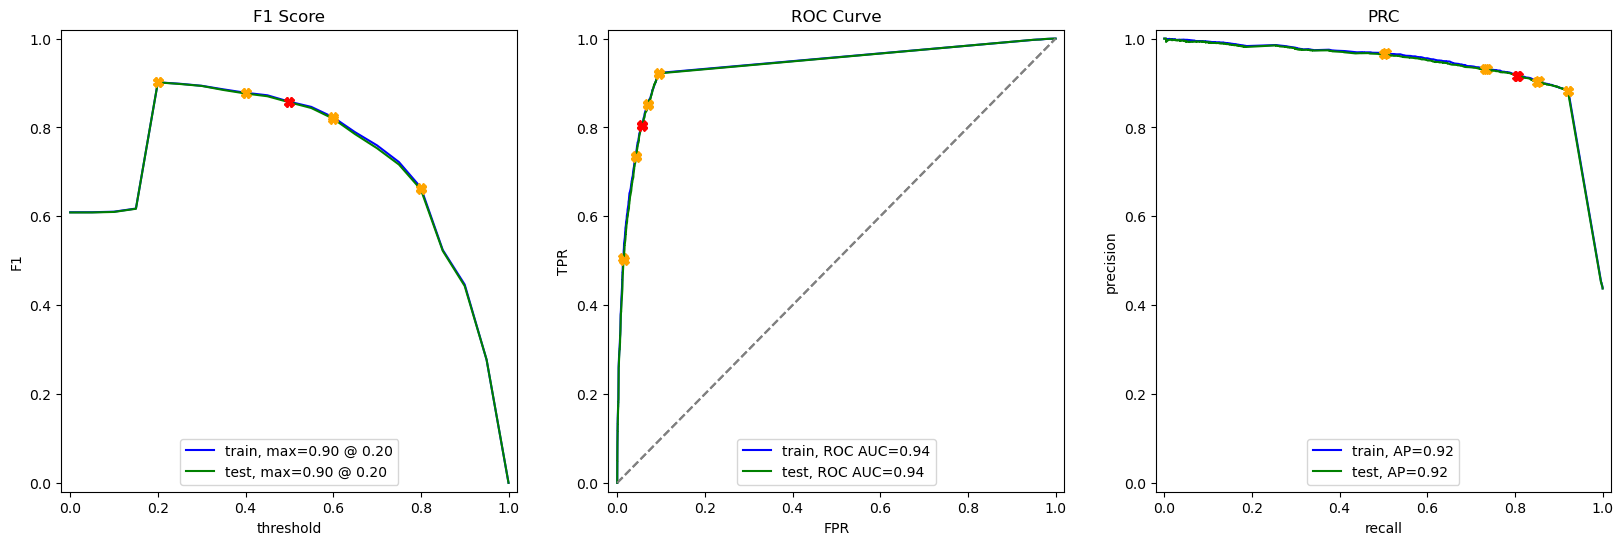

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.943091,0.056909
Is True,0.195832,0.804168


,Predicted False,Predicted True
Is False,38248,2308
Is True,6174,25353


CPU times: user 4min 30s, sys: 7.35 s, total: 4min 38s
Wall time: 59 s


In [215]:
%%time

from catboost import CatBoostClassifier

model_4 = make_pipeline(
    TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1)),
    CatBoostClassifier(
        iterations=250, 
        learning_rate=0.1,
        depth=3, 
        eval_metric='F1',
        random_seed=42,
        verbose=0,
        early_stopping_rounds=100
    )
)

# Train the model
model_4.fit(features_train, target_train)

# Predict on the test data
predictions = model_4.predict(features_test)

evaluate_model(model_4, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

### 5.6. Model 5 - TF-IDF and LGBMClassifier

[LightGBM] [Info] Number of positive: 126265, number of negative: 162065
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.617663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242255
[LightGBM] [Info] Number of data points in the train set: 288330, number of used features: 6106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437918 -> initscore=-0.249615
[LightGBM] [Info] Start training from score -0.249615
             train      test
Accuracy  0.919141  0.915972
F1        0.905880  0.902024
APS       0.960986  0.957699
ROC AUC   0.968611  0.966548


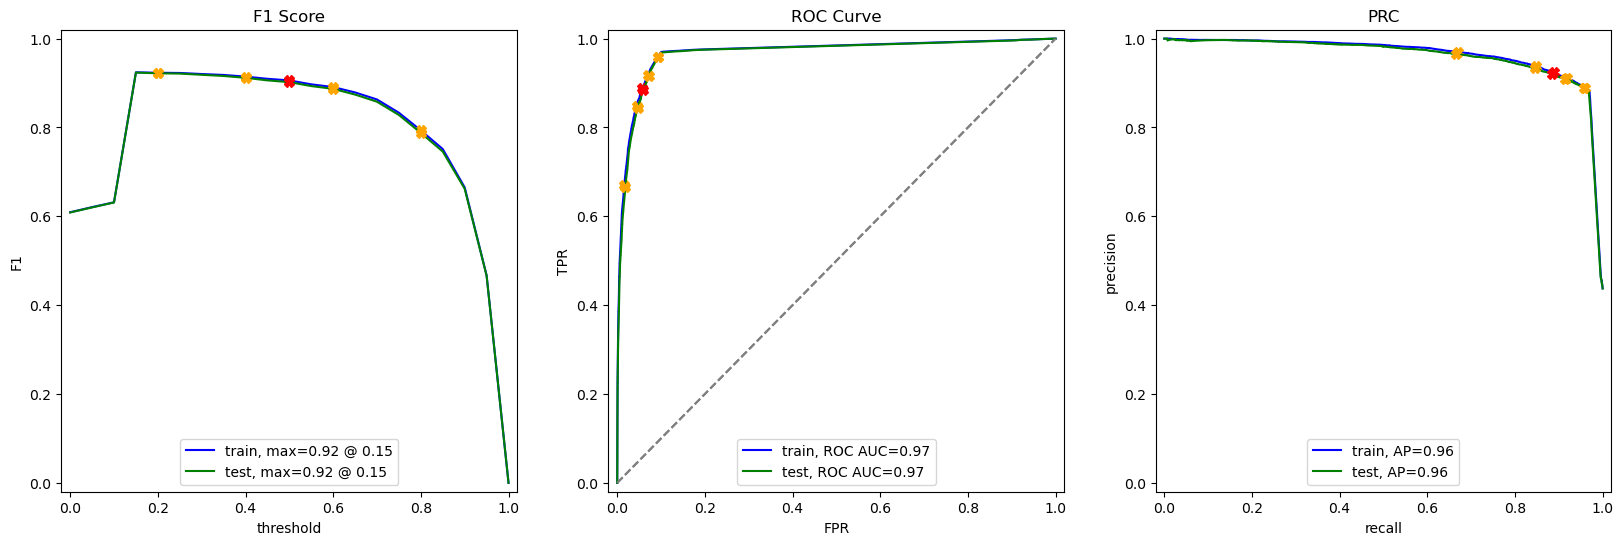

Confusion matrixes for the model are below, first by percentage, then by instances.


,Predicted False,Predicted True
Is False,0.940527,0.059473
Is True,0.115615,0.884385


,Predicted False,Predicted True
Is False,38144,2412
Is True,3645,27882


CPU times: user 1min 24s, sys: 8.03 s, total: 1min 32s
Wall time: 23.4 s


In [221]:
%%time

from lightgbm import LGBMClassifier

model_5 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words=stop_words),  # Convert text to TF-IDF model
    LGBMClassifier(boosting_type='gbdt')  # LGBMClassifier model
)

# Train the model
model_5.fit(features_train, target_train)

# Predict on the test data
predictions = model_5.predict(features_test)

evaluate_model(model_5, features_train, target_train, features_test, target_test)
structure_confusion_matrix(confusion_matrix(target_test, predictions))

## 6. Model Comparison

In [244]:
eval_stats_all = eval_stats_all.drop_duplicates()
eval_stats_all.sort_values(by='test_roc_auc', ascending=False)

,model_name,full_model,test_accuracy,test_f1,test_roc_auc,test_aps
1,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.948296,0.939964,0.981324,0.978071
3,Pipeline,"Pipeline(memory=None, steps=[('countvectorizer...",0.957091,0.950403,0.975571,0.969533
4,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.915972,0.902024,0.966548,0.957699
15,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.882330,0.856694,0.936816,0.918779
2,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.783111,0.694302,0.844931,0.834127
0,DummyClassifier,"DummyClassifier(constant=1, random_state=42, s...",0.437371,0.608571,0.500000,0.437371


In [246]:
df_model.shape, vaders.shape

((450517, 10), (360413, 14))

In [248]:
eval_stats_all.sort_values(by='test_accuracy', ascending=False)

,model_name,full_model,test_accuracy,test_f1,test_roc_auc,test_aps
3,Pipeline,"Pipeline(memory=None, steps=[('countvectorizer...",0.957091,0.950403,0.975571,0.969533
1,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.948296,0.939964,0.981324,0.978071
4,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.915972,0.902024,0.966548,0.957699
15,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.882330,0.856694,0.936816,0.918779
2,Pipeline,"Pipeline(memory=None, steps=[('tfidfvectorizer...",0.783111,0.694302,0.844931,0.834127
0,DummyClassifier,"DummyClassifier(constant=1, random_state=42, s...",0.437371,0.608571,0.500000,0.437371


In [241]:
eval_stats_all.sort_values(by='test_accuracy', ascending=False)['full_model'][3]

'Pipeline(memory=None, steps=[(\'countvectorizer\', CountVectorizer(stop_words=[\'very\', \'over\', \'will\', \'too\', \'because\', \'once\',\n                            \'having\', \'s\', \'not\', \'for\', \'the\', \'with\', \'y\',\n                            \'under\', \'shan\', "couldn\'t", "it\'s", "hadn\'t",\n                            \'doesn\', \'himself\', \'on\', \'after\', \'here\', \'so\',\n                            \'of\', "you\'ll", \'have\', \'does\', \'through\', \'just\', ...])), (\'logisticregression\', LogisticRegression(max_iter=1000))], verbose=False, countvectorizer=CountVectorizer(stop_words=[\'very\', \'over\', \'will\', \'too\', \'because\', \'once\',\n                            \'having\', \'s\', \'not\', \'for\', \'the\', \'with\', \'y\',\n                            \'under\', \'shan\', "couldn\'t", "it\'s", "hadn\'t",\n                            \'doesn\', \'himself\', \'on\', \'after\', \'here\', \'so\',\n                            \'of\', "you\'ll"

The model with the highest accuracy is a combo of CountVectorizer and LogisticRegression.

### 6.0. Unseen text

About 20% of the dataset was not used for modeling purposes. It is used below to test the model's efficiency at classifying text. I call vaders again to reorient myself with the data. The last 20% is in a dataframe called 'test'.

In [254]:
vaders

,neg,neu,pos,compound,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date
1794,0.082,0.782,0.135,0.4396,hey why don t you go yourselves bob go yoursel...,0.0,0.0,155,25,201420,1940,1481,2296,27.09
189032,0.000,0.345,0.655,0.5859,that wa amazing,1.0,0.0,76,10,1026622,61409,967,4097,13.09
168824,0.103,0.751,0.146,0.2263,can you describe it and she no n with rainbow ...,0.0,0.0,714,1,1911216,15633,1031,2253,28.09
91943,0.081,0.543,0.376,0.8225,honestly love this man saw it on and just had ...,0.0,0.0,277,24,714616,29662,135,640,11.10
244596,0.000,0.588,0.412,0.6369,i love this woman with all my heart,0.0,0.0,880,10,404187,28947,511,1631,19.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.000,0.000,1.000,0.3612,i like,0.0,0.0,121,15,433887,16784,206,2858,21.09
259178,0.000,1.000,0.000,0.0000,the white boy dance at,1.0,0.0,934,23,57504,3299,101,388,28.09
131932,0.000,1.000,0.000,0.0000,is garbage for dough,0.0,0.0,287,17,367178,5296,199,2422,14.09
146867,0.000,0.417,0.583,0.6369,the best video ever,1.0,0.0,55,23,711388,60163,685,4513,21.09


In [264]:
test.shape

(90104, 10)

In [293]:
test = test.sample(frac=1, random_state=42)

In [295]:
test['sentiment'] = model_3.predict(test['comment_text'])

model_3 performed the best.

In [351]:
pd.set_option('display.max_colwidth', 1000)
test.loc[:, ['comment_text', 'sentiment']].sample(10, random_state=42)

,comment_text,sentiment
53144,um how about not our coast line be looking fire and you know our de caracol is lit,0
176480,where did link get his jacket,0
225426,feel blessed,1
197142,ce dislike,0
285630,no brain it s not stop reading it that way,0
413494,emotional intelligence sound like a contradiction but sometimes when you ask the question is a important a understanding the answer,1
319287,,0
269487,poor guy,0
28109,ai will be the threat to mankind,0
169068,i feel bad for the person who ha to clean up that suck,0


In [379]:
test_set = test.loc[:, ['comment_text', 'sentiment']].sample(10, random_state=42).reset_index(drop=True)

In [381]:
model_3.predict(pd.Series("I am so happy"))

array([1])

In [383]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [417]:
test_set

,comment_text,sentiment,polarity
0,um how about not our coast line be looking fire and you know our de caracol is lit,0,
1,where did link get his jacket,0,
2,feel blessed,1,
3,ce dislike,0,
4,no brain it s not stop reading it that way,0,
5,emotional intelligence sound like a contradiction but sometimes when you ask the question is a important a understanding the answer,1,
6,,0,
7,poor guy,0,
8,ai will be the threat to mankind,0,
9,i feel bad for the person who ha to clean up that suck,0,


In [427]:
test_set['polarity'] = test_set['comment_text'].apply(lambda x: sia.polarity_scores(x))

# If you want to separate out the individual sentiment components, you can do this:
test_set[['neg', 'neu', 'pos', 'compound']] = pd.json_normalize(test_set['polarity'])
test_set.drop(columns='polarity', inplace=True)

test_set

,comment_text,sentiment,neg,neu,pos,compound
0,um how about not our coast line be looking fire and you know our de caracol is lit,0,0.124,0.876,0.000,-0.3400
1,where did link get his jacket,0,0.000,1.000,0.000,0.0000
2,feel blessed,1,0.000,0.204,0.796,0.5994
3,ce dislike,0,0.722,0.278,0.000,-0.3818
4,no brain it s not stop reading it that way,0,0.198,0.631,0.170,-0.0803
5,emotional intelligence sound like a contradiction but sometimes when you ask the question is a important a understanding the answer,1,0.072,0.577,0.351,0.5859
6,,0,0.000,0.000,0.000,0.0000
7,poor guy,0,0.756,0.244,0.000,-0.4767
8,ai will be the threat to mankind,0,0.362,0.638,0.000,-0.5267
9,i feel bad for the person who ha to clean up that suck,0,0.328,0.410,0.262,-0.3182


The models were trained sentiment scores that were provided by sia.polarity_scores() but those scores are provided here to check how our model is performing at classifying text as poitive and negative. There's an issue in that there's an empty field for comment_text, but this section of the data did not go through the same preprocessing cleaning before modeling. In all cases above, our model predicts a sentiment that is in accordance with the compound sentiment score, specifically on text that the model has never seen before. About 90,000 comments are available for comparison if more testing is desired.

In [440]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90104 entries, 46985 to 350461
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   comment_text    90104 non-null  object 
 1   comments_likes  90104 non-null  float64
 2   replies         90104 non-null  float64
 3   channel_title   90104 non-null  int64  
 4   category_id     90104 non-null  int64  
 5   views           90104 non-null  int64  
 6   video_likes     90104 non-null  int64  
 7   video_dislikes  90104 non-null  int64  
 8   comment_total   90104 non-null  int64  
 9   date            90104 non-null  float64
 10  sentiment       90104 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 8.2+ MB


In [445]:
df_model['sentiment'] = model_3.predict((df_model['comment_text'].apply(comments)).apply(get_lemmas))
df_model

,comment_text,comments_likes,replies,channel_title,category_id,views,video_likes,video_dislikes,comment_total,date,sentiment
0,it s yo big day,4.0,0.0,563,24,4394029,320053,5931,46245,13.09,0
1,i been following you from the start of your vine channel and have seen all,3.0,0.0,563,24,4394029,320053,5931,46245,13.09,0
2,say hi to and maverick for me,3.0,0.0,563,24,4394029,320053,5931,46245,13.09,0
3,my fan attendance,3.0,0.0,563,24,4394029,320053,5931,46245,13.09,1
4,,3.0,0.0,563,24,4394029,320053,5931,46245,13.09,0
...,...,...,...,...,...,...,...,...,...,...,...
450512,lost on you my god i love this song,0.0,0.0,527,10,84755,5763,44,413,19.10,1
450513,i love,0.0,0.0,527,10,84755,5763,44,413,19.10,1
450514,l o s t o n y o u,1.0,0.0,527,10,84755,5763,44,413,19.10,0
450515,,0.0,0.0,527,10,84755,5763,44,413,19.10,0


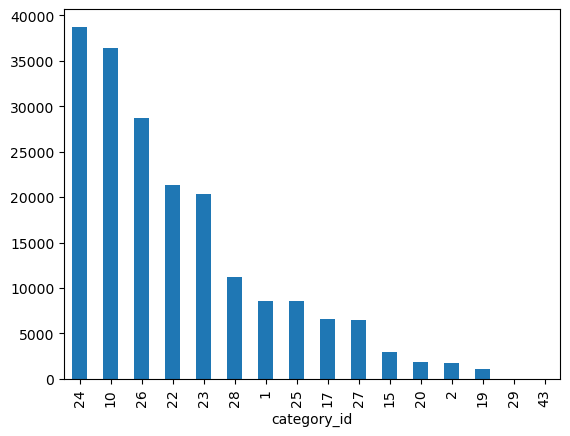

In [506]:
df_model.groupby('category_id')['sentiment'].sum().sort_values(ascending=False).plot(kind='bar')
plt.show()

In [520]:
set(df_model['category_id']).map(category_mapping)

AttributeError: 'set' object has no attribute 'map'

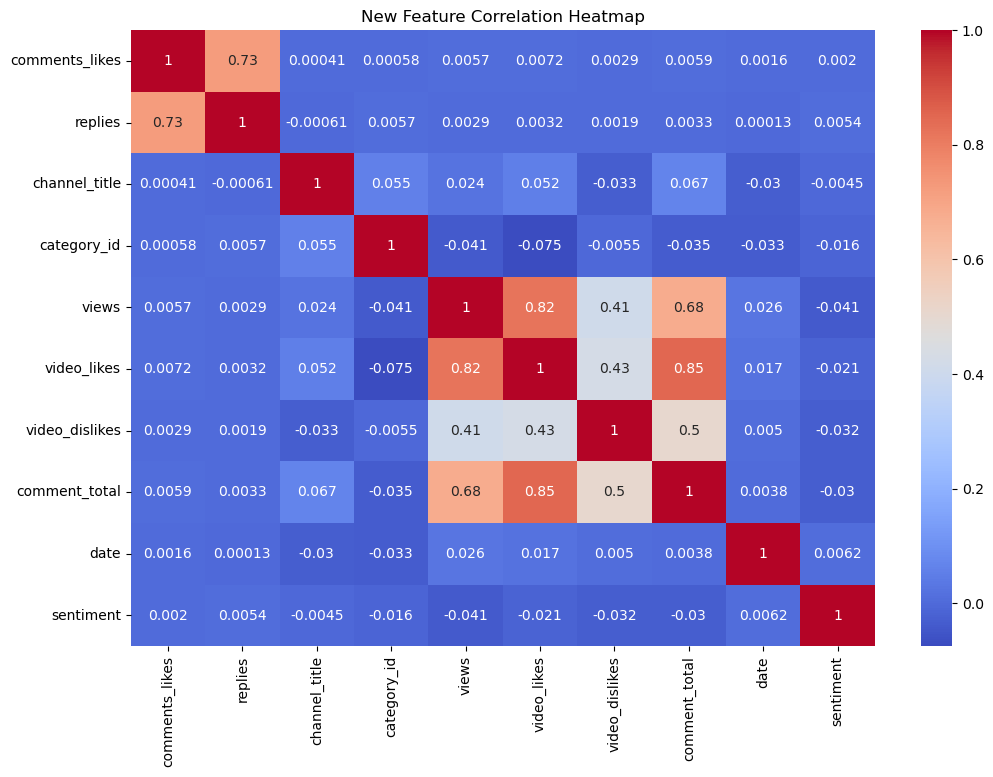

In [461]:
# Heatmap of numeric feature correlations
plt.figure(figsize=(12, 8))
sns.heatmap(df_model.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('New Feature Correlation Heatmap')
plt.show()

Comment sentiment does not seem to have correlations with the other fields. The sentiment field is binary and maybe a positive, negative, and neutral division multiclassifier division might change how the correlated the sentiment field is.

## 7. Conclusions